In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
sys.path.insert(1, '/home/georgeos/Documents/GitHub/SyMBac/') # Not needed if you installed SyMBac using pip
sys.path.insert(1, '/home/georgeos/Documents/Github/SyMBac/') # Not needed if you installed SyMBac using pip
from cellpose import models, core
use_GPU = core.use_gpu()

from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
from skimage.util import img_as_uint
import zarr
from numcodecs import Blosc
from joblib import Parallel, delayed
from glob import glob
from skimage.filters.thresholding import threshold_isodata, threshold_li, threshold_minimum, threshold_triangle, threshold_mean, threshold_otsu, threshold_yen, threshold_local, threshold_niblack, threshold_sauvola
import pandas as pd
import seaborn as sns
from sklearn.metrics import jaccard_score

from cellpose import plot
import omnipose
from cellpose import models


def flatten(l):
    return [item for sublist in l for item in sublist]

def global_threshold(function, image):
    thresh = function(image)
    binary = image > thresh
    return binary

def default_threshold_local(image):
    return threshold_local(image, block_size=11)

def default_threshold_sauvola(image):
    return threshold_sauvola(image, window_size=123)

def default_threshold_niblack(image):
    return threshold_niblack(image, window_size=263)

def file_to_dict(filename):
    length, width, wavelength, name, NA, n =  filename.split("/")[1].split("_")
    length, width, wavelength, NA, n = float(length), float(width), float(wavelength), float(NA), float(n.split(".zarr")[0])

    data = {
        "length" : length,
        "width" : width,
        "wavelength" : wavelength,
        "NA": NA,
        "n" : n,
        "name" : name,
        "data" : zarr.open(filename)
           }
    
    return data

def perc_error(actual, theoretical, signed = False):
    error = (actual - theoretical)/theoretical * 100
    if not signed:
        return abs(error)
    return error

def try_all_global_threshold(image):
    functions = [threshold_isodata, threshold_li, threshold_triangle, threshold_mean, threshold_otsu, threshold_yen] 
    function_names = ["Isodata", "Li", "Triangle", "Mean", "Otsu", "Yen"]
    binary_imgs = {}
    for function, name in zip(functions, function_names):
        try:
            binary_imgs[name] = global_threshold(function, image)
        except:
            binary_imgs[name] = np.nan
    #binary_imgs = {name : global_threshold(function, image) for (function, name) in zip(functions, function_names)}
    return binary_imgs

def try_all_local_threshold(image):
    functions = [default_threshold_local, default_threshold_sauvola, default_threshold_niblack] 
    function_names = ["SkImage local", "Sauvola", "Niblack"]
    binary_imgs = {}
    for function, name in zip(functions, function_names):
        try:
            binary_imgs[name] = global_threshold(function, image)
        except:
            binary_imgs[name] = np.nan
    #binary_imgs = {name : global_threshold(function, image) for (function, name) in zip(functions, function_names)}
    return binary_imgs

def get_mask_error_of_stack(mask_stack, true_cell_mask, signed = False):
    true_area = np.sum(true_cell_mask)
    errors = []
    for mask in mask_stack:
        actual_area = np.sum(mask)
        error = perc_error(actual_area, true_area, signed = signed)
        errors.append(error)
    return errors

def get_areas_of_thresholds(thresholds):
    threshold_areas = {}
    for function, data in thresholds.items():
        if data is np.nan:
            threshold_areas[function] = np.nan
        else:
            threshold_areas[function] = np.sum(data)
    return threshold_areas

#for file in tqdm(files):
def get_global_threshold_df_data(file):
    all_data = []
    data = file_to_dict(file)
    image = np.concatenate(data["data"], axis=1)
    cell_length = data["length"]
    cell_width = data["width"]
    wavelength = data["wavelength"]
    NA = data["NA"]
    n = data["n"]
    resize_amount = 1
    pix_mic_conv = 0.065 #micron/pix
    raster_cell_length = cell_length/pix_mic_conv * resize_amount
    raster_cell_width = cell_width/pix_mic_conv * resize_amount
    cell = np.pad(raster_cell(raster_cell_length, raster_cell_width, separation=0), ((100,100),(200,200)))
    cell_mask = cell > 0
    true_area = np.sum(cell_mask)
    thresholds = try_all_global_threshold(image)
    for function, data in thresholds.items():
        if data is np.nan:
            for density in densities:
                output = [function, density, np.nan]
                output += [cell_length, cell_width, true_area, wavelength, NA, n]
                all_data.append(output)
        else:
            split_masks = np.array_split(data, len(densities), axis=1)
            for mask, density in zip(split_masks, densities):
                area = np.sum(mask)
                IoU = jaccard_score(cell_mask, mask, average="micro")
                output = [function, density, area, IoU]
                output += [cell_length, cell_width, true_area, wavelength, NA, n]
                all_data.append(output)
    return all_data

#for file in tqdm(files):
def get_local_threshold_df_data(file):
    all_data = []
    data = file_to_dict(file)
    image = np.concatenate(data["data"], axis=1)
    cell_length = data["length"]
    cell_width = data["width"]
    wavelength = data["wavelength"]
    NA = data["NA"]
    n = data["n"]
    resize_amount = 1
    pix_mic_conv = 0.065 #micron/pix
    raster_cell_length = cell_length/pix_mic_conv * resize_amount
    raster_cell_width = cell_width/pix_mic_conv * resize_amount
    cell = np.pad(raster_cell(raster_cell_length, raster_cell_width, separation=0), ((100,100),(200,200)))
    cell_mask = cell > 0
    true_area = np.sum(cell_mask)
    thresholds = try_all_local_threshold(image)
    for function, data in thresholds.items():
        if data is np.nan:
            for density in densities:
                output = [function, density, np.nan]
                output += [cell_length, cell_width, true_area, wavelength, NA, n]
                all_data.append(output)
        else:
            split_masks = np.array_split(data, len(densities), axis=1)
            for mask, density in zip(split_masks, densities):
                area = np.sum(mask)
                IoU = jaccard_score(cell_mask, mask, average="micro")
                output = [function, density, area, IoU]
                output += [cell_length, cell_width, true_area, wavelength, NA, n]
                all_data.append(output)
    return all_data

2023-02-21 05:58:13,351 [INFO] ** TORCH GPU version installed and working. **


In [2]:
files = glob("convolutions/*")
densities = np.linspace(1,100, 10)
all_data = pd.DataFrame()

In [3]:
all_data = Parallel(n_jobs=-1)(delayed(get_global_threshold_df_data)(file) for file in tqdm(files))

  0%|          | 0/4181 [00:00<?, ?it/s]

/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *
/home/georgeos/miniconda3/lib/python3.10/site-packages/skimage/filters/thresholding.py:440: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


In [4]:
all_data_clean = [i for i in all_data if i is not None]
all_data_clean = (flatten(all_data_clean))
all_data_global_threshold = pd.DataFrame(all_data_clean)
all_data_global_threshold.columns = ["Threshold method", "Intensity", "Measured area", "IoU", "Cell length (micron)", "Cell width (micron)", "True area", "Wavelength (micron)", "NA", "n"]
all_data_global_threshold = all_data_global_threshold[all_data_global_threshold["Wavelength (micron)"] != 0.6]
all_data_global_threshold["% Error"] = abs(all_data_global_threshold["Measured area"] - all_data_global_threshold["True area"])/all_data_global_threshold["True area"] * 100
all_data_global_threshold["Signed % Error"] = (all_data_global_threshold["Measured area"] - all_data_global_threshold["True area"])/all_data_global_threshold["True area"] * 100
all_data_global_threshold["Measured area/True area"] = all_data_global_threshold["Measured area"]/all_data_global_threshold["True area"]

<AxesSubplot:xlabel='Intensity', ylabel='% Error'>

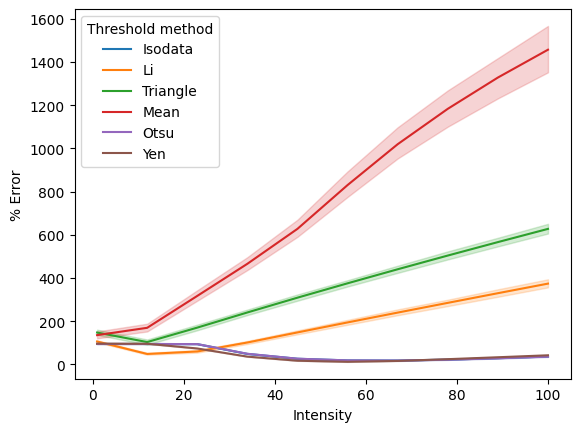

In [5]:
sns.lineplot(x="Intensity", y="% Error",
             hue="Threshold method",
             data=all_data_global_threshold)
#plt.yscale("log")

<AxesSubplot:xlabel='Intensity', ylabel='IoU'>

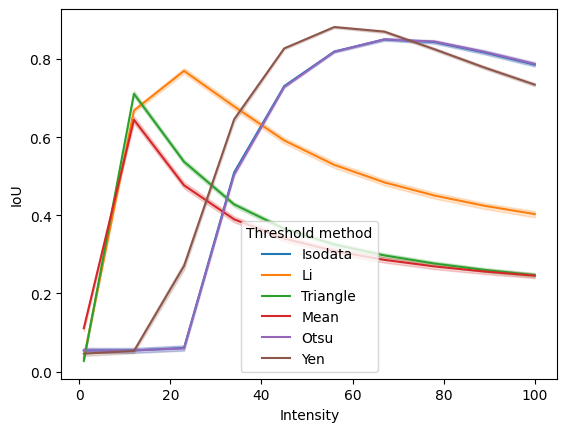

In [6]:
sns.lineplot(x="Intensity", y="IoU",
             hue="Threshold method",
             data=all_data_global_threshold)
#plt.yscale("log")

(-0.1, 1.0)

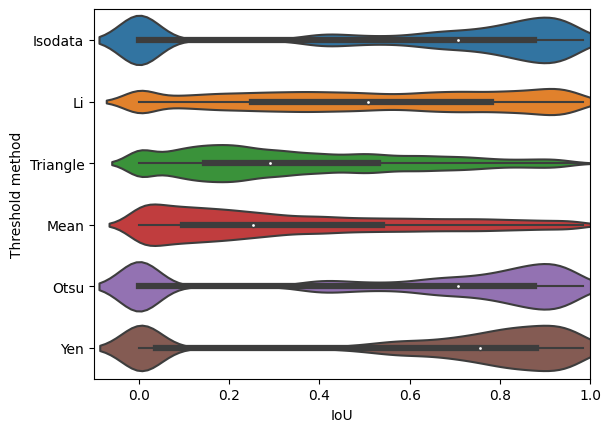

In [7]:
sns.violinplot(data=all_data_global_threshold, x="IoU", y="Threshold method")
plt.xlim(-0.1,1)

(-10.0, 1000.0)

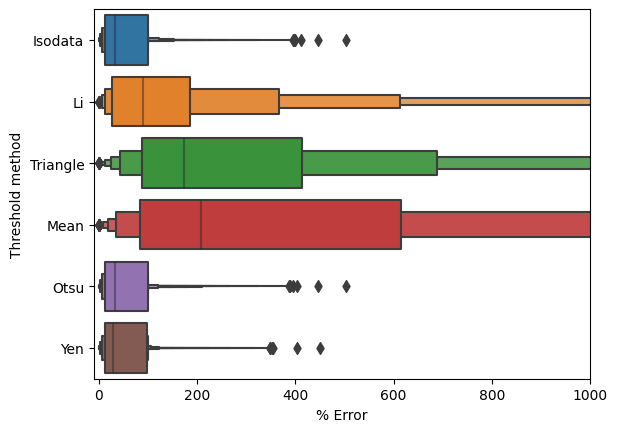

In [8]:
sns.boxenplot(data=all_data_global_threshold, x="% Error", y="Threshold method")
plt.xlim(-10,1000)

<AxesSubplot:xlabel='Intensity', ylabel='IoU'>

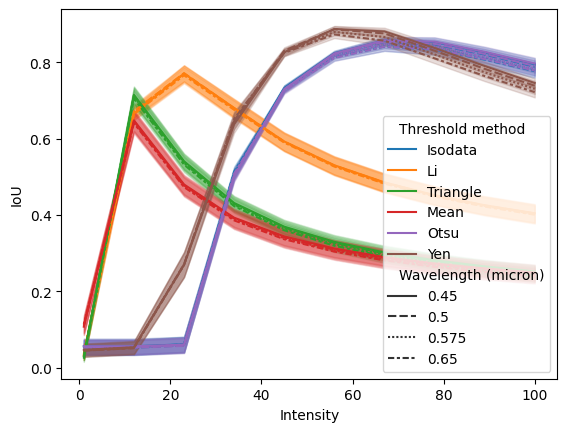

In [9]:
sns.lineplot(x="Intensity", y="IoU",
             hue="Threshold method",style="Wavelength (micron)",
             data=all_data_global_threshold, errorbar=("se", 3))

In [10]:
all_data_local = Parallel(n_jobs=-1)(delayed(get_local_threshold_df_data)(file) for file in tqdm(files))

  0%|          | 0/4181 [00:00<?, ?it/s]

In [11]:
all_data_local_clean = [i for i in all_data_local if i is not None]
all_data_local_clean = (flatten(all_data_local_clean))
all_data_local_threshold = pd.DataFrame(all_data_local_clean)
all_data_local_threshold.columns = ["Threshold method", "Intensity", "Measured area", "IoU", "Cell length (micron)", "Cell width (micron)", "True area", "Wavelength (micron)", "NA", "n"]
all_data_local_threshold = all_data_local_threshold[all_data_local_threshold["Wavelength (micron)"] != 0.6]
all_data_local_threshold["% Error"] = abs(all_data_local_threshold["Measured area"] - all_data_local_threshold["True area"])/all_data_local_threshold["True area"] * 100
all_data_local_threshold["Signed % Error"] = (all_data_local_threshold["Measured area"] - all_data_local_threshold["True area"])/all_data_local_threshold["True area"] * 100
all_data_local_threshold["Measured area/True area"] = all_data_local_threshold["Measured area"]/all_data_local_threshold["True area"]

<AxesSubplot:xlabel='Intensity', ylabel='% Error'>

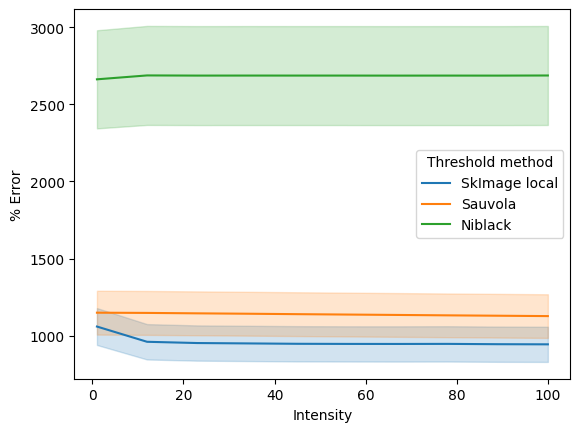

In [12]:
sns.lineplot(x="Intensity", y="% Error",
             hue="Threshold method",
             data=all_data_local_threshold, errorbar=("se", 3))
#plt.yscale("log")

<AxesSubplot:xlabel='Intensity', ylabel='IoU'>

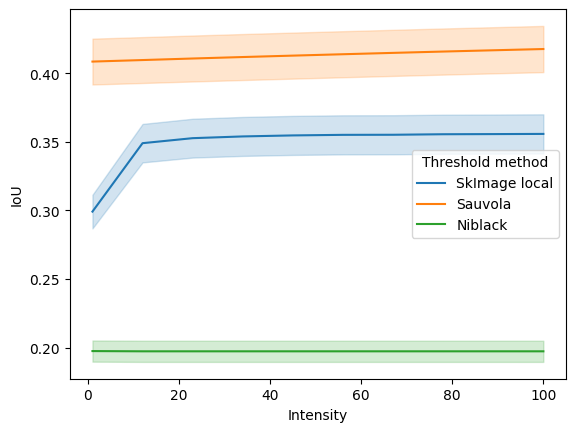

In [13]:
sns.lineplot(x="Intensity", y="IoU",
             hue="Threshold method",
             data=all_data_local_threshold, errorbar=("se", 3))
#plt.yscale("log")

In [107]:
import random
sample_files = random.sample(files, k=20)

In [108]:
from cellpose import io, transforms
from omnipose.utils import normalize99
from natsort import natsorted

In [109]:
model_files = natsorted(glob("synthetic_training_data/models/*"))

In [89]:
file = sample_files[0]
all_data = []
data = file_to_dict(file)
imgs = data["data"]
imgs = [x for x in imgs]
cell_length = data["length"]
cell_width = data["width"]
wavelength = data["wavelength"]
NA = data["NA"]
RI = data["n"]
resize_amount = 1
pix_mic_conv = 0.065 #micron/pix
raster_cell_length = cell_length/pix_mic_conv * resize_amount
raster_cell_width = cell_width/pix_mic_conv * resize_amount
cell = np.pad(raster_cell(raster_cell_length, raster_cell_width, separation=0), ((100,100),(200,200)))
cell_mask = cell > 0
true_area = np.sum(cell_mask)





nimg = len(imgs)

for k in range(len(imgs)):
    img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
    if len(img.shape)>2:
        imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 

    imgs[k] = normalize99(imgs[k])
    chans = [0,0] #this means segment based on first channel, no second channel

n = [0] # make a list of integers to select which images you want to segment
n = range(nimg) # or just segment them all

# define parameters
mask_threshold = -1
verbose = 0 # turn on if you want to see more output
use_gpu = use_GPU #defined above
transparency = True # transparency in flow output
rescale=3 # give this a number if you need to upscale or downscale your images
omni = True # we can turn off Omnipose mask reconstruction, not advised
flow_threshold = 0.4# default is .4, but only needed if there are spurious masks to clean up; slows down output
resample = True #whether or not to run dynamics on rescaled grid or original grid
masks, flows, styles = model.eval([imgs[i]*100 for i in n],channels=chans,rescale=rescale,mask_threshold=mask_threshold,transparency=transparency,
                                  flow_threshold=flow_threshold,omni=omni,resample=resample,verbose=verbose)



for mask, density in zip(masks, densities):
    area = np.sum(mask)
    IoU = jaccard_score(cell_mask, mask>0, average="micro")
    output = ["Omnipose retrained", density, area, IoU]

    output += [cell_length, cell_width, true_area, wavelength, NA, RI]
    all_data.append(output)

2023-02-21 00:46:24,849 [INFO] 
2023-02-21 00:46:24,849 [INFO] 0%|          | 0/10 [00:00<?, ?it/s]
2023-02-21 00:46:24,850 [INFO] 
2023-02-21 00:46:25,594 [INFO] 
2023-02-21 00:46:25,595 [INFO] 10%|#         | 1/10 [00:00<00:06,  1.34it/s]
2023-02-21 00:46:25,595 [INFO] 
2023-02-21 00:46:26,280 [INFO] 
2023-02-21 00:46:26,280 [INFO] 20%|##        | 2/10 [00:01<00:05,  1.41it/s]
2023-02-21 00:46:26,280 [INFO] 
2023-02-21 00:46:26,973 [INFO] 
2023-02-21 00:46:26,974 [INFO] 30%|###       | 3/10 [00:02<00:04,  1.42it/s]
2023-02-21 00:46:26,974 [INFO] 
2023-02-21 00:46:27,675 [INFO] 
2023-02-21 00:46:27,675 [INFO] 40%|####      | 4/10 [00:02<00:04,  1.42it/s]
2023-02-21 00:46:27,676 [INFO] 
2023-02-21 00:46:28,369 [INFO] 
2023-02-21 00:46:28,370 [INFO] 50%|#####     | 5/10 [00:03<00:03,  1.43it/s]
2023-02-21 00:46:28,370 [INFO] 
2023-02-21 00:46:29,034 [INFO] 
2023-02-21 00:46:29,034 [INFO] 60%|######    | 6/10 [00:04<00:02,  1.45it/s]
2023-02-21 00:46:29,035 [INFO] 
2023-02-21 00:46:29,71

In [110]:
use_gpu = use_GPU# = False
def segment_with_omnipose(file):
    
    all_data = []
    data = file_to_dict(file)
    imgs = data["data"]
    cell_length = data["length"]
    cell_width = data["width"]
    wavelength = data["wavelength"]
    NA = data["NA"]
    RI = data["n"]
    resize_amount = 1
    pix_mic_conv = 0.065 #micron/pix
    raster_cell_length = cell_length/pix_mic_conv * resize_amount
    raster_cell_width = cell_width/pix_mic_conv * resize_amount
    cell = np.pad(raster_cell(raster_cell_length, raster_cell_width, separation=0), ((100,100),(200,200)))
    cell_mask = cell > 0
    true_area = np.sum(cell_mask)
    
    
    


    nimg = len(imgs)

    for k in range(len(imgs)):
        img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
        if len(img.shape)>2:
            imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 

        imgs[k] = normalize99(imgs[k])
        chans = [0,0] #this means segment based on first channel, no second channel

    n = [0] # make a list of integers to select which images you want to segment
    n = range(nimg) # or just segment them all

    # define parameters
    mask_threshold = -1
    verbose = 0 # turn on if you want to see more output
    use_gpu = use_GPU #defined above
    transparency = True # transparency in flow output
    rescale=3 # give this a number if you need to upscale or downscale your images
    omni = True # we can turn off Omnipose mask reconstruction, not advised
    flow_threshold = 0.4 # default is .4, but only needed if there are spurious masks to clean up; slows down output
    resample = True #whether or not to run dynamics on rescaled grid or original grid
    masks, flows, styles = model.eval([imgs[i] for i in n],channels=chans,rescale=rescale,mask_threshold=mask_threshold,transparency=transparency,
                                      flow_threshold=flow_threshold,omni=omni,resample=resample,verbose=verbose)

    
    
    for mask, density in zip(masks, densities):
        area = np.sum(mask)
        IoU = jaccard_score(cell_mask, mask>0, average="micro")
        output = ["Omnipose retrained", density, area, IoU]
        
        output += [cell_length, cell_width, true_area, wavelength, NA, RI]
        all_data.append(output)
    return all_data

In [111]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

synthetic_training_data/models/cellpose_residual_on_style_on_concatenation_off_omni_nclasses_4_synthetic_training_data_2023_02_14_05_21_31.495134_epoch_7901
2023-02-21 00:55:36,664 [INFO] ** TORCH GPU version installed and working. **
2023-02-21 00:55:36,664 [INFO] >>>> using GPU


  0%|          | 0/20 [00:00<?, ?it/s]

2023-02-21 00:56:32,499 [INFO] 100%|##########| 10/10 [00:11<00:00,  1.11s/it]


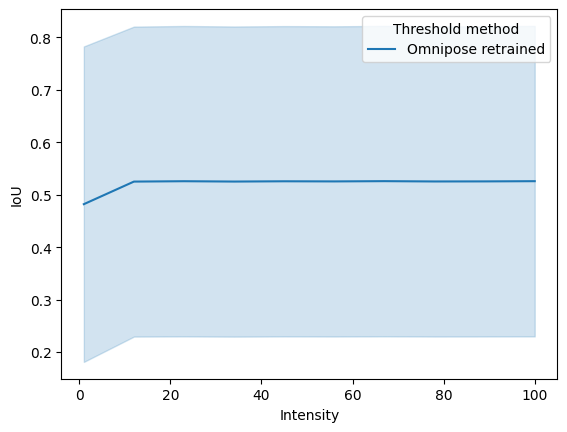

In [112]:
all_data_all_epochs = []
for epoch in [model_files[-1]]:
    print(epoch)
    model = models.CellposeModel(gpu=use_gpu, pretrained_model=epoch, omni=True, concatenation=True)
    all_data_omni_retrained = Parallel(n_jobs=5)(delayed(segment_with_omnipose)(file) for file in tqdm(sample_files))
    all_data_all_epochs.append(all_data_omni_retrained)
    all_data_omni_re_clean = [i for i in all_data_omni_retrained if i is not None]
    all_data_omni_re_clean = (flatten(all_data_omni_re_clean))
    all_data_omni_re = pd.DataFrame(all_data_omni_re_clean)
    all_data_omni_re.columns = ["Threshold method", "Intensity", "Measured area", "IoU", "Cell length (micron)", "Cell width (micron)", "True area", "Wavelength (micron)", "NA", "n"]
    all_data_omni_re = all_data_omni_re[all_data_omni_re["Wavelength (micron)"] != 0.6]
    all_data_omni_re["% Error"] = abs(all_data_omni_re["Measured area"] - all_data_omni_re["True area"])/all_data_omni_re["True area"] * 100
    all_data_omni_re["Signed % Error"] = (all_data_omni_re["Measured area"] - all_data_omni_re["True area"])/all_data_omni_re["True area"] * 100
    all_data_omni_re["Measured area/True area"] = all_data_omni_re["Measured area"]/all_data_omni_re["True area"]
    sns.lineplot(x="Intensity", y="IoU", hue="Threshold method", data=all_data_omni_re, errorbar=("se", 3))
    plt.show()
#plt.yscale("log") 

In [113]:
all_data_omni_re_clean = [i for i in all_data_omni_retrained if i is not None]
all_data_omni_re_clean = (flatten(all_data_omni_re_clean))
all_data_omni_re = pd.DataFrame(all_data_omni_re_clean)
all_data_omni_re.columns = ["Threshold method", "Intensity", "Measured area", "IoU", "Cell length (micron)", "Cell width (micron)", "True area", "Wavelength (micron)", "NA", "n"]
all_data_omni_re = all_data_omni_re[all_data_omni_re["Wavelength (micron)"] != 0.6]
all_data_omni_re["% Error"] = abs(all_data_omni_re["Measured area"] - all_data_omni_re["True area"])/all_data_omni_re["True area"] * 100
all_data_omni_re["Signed % Error"] = (all_data_omni_re["Measured area"] - all_data_omni_re["True area"])/all_data_omni_re["True area"] * 100
all_data_omni_re["Measured area/True area"] = all_data_omni_re["Measured area"]/all_data_omni_re["True area"]

In [ ]:
sns.lineplot(x="Intensity", y="IoU",
             data=all_data_omni_re, errorbar=("se", 1), style="NA", hue="Wavelength (micron)")
#plt.yscale("log")

[autoreload of six failed: Traceback (most recent call last):
  File "/home/georgeos/miniconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/georgeos/miniconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/home/georgeos/miniconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/home/georgeos/miniconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 314, in update_class
    old_obj = getattr(old, key)
  File "/home/georgeos/miniconda3/lib/python3.10/site-packages/six.py", line 98, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of dateutil.tz._factories failed: Traceback (most recent call last):
  File "/home/georgeos/

In [27]:
use_gpu = use_GPU# = False
model = models.CellposeModel(gpu=use_gpu, pretrained_model="bact_fluor_omni", omni=True, concatenation=True)

2023-02-14 16:15:50,808 [WARNING] pretrained model has incorrect path
2023-02-14 16:15:50,808 [INFO] >>cyto<< model set to be used
2023-02-14 16:15:50,810 [INFO] ** TORCH GPU version installed and working. **
2023-02-14 16:15:50,811 [INFO] >>>> using GPU


In [28]:
all_data_omni_pretrained = Parallel(n_jobs=6)(delayed(segment_with_omnipose)(file) for file in tqdm(sample_files))

  0%|          | 0/150 [00:00<?, ?it/s]

In [31]:
all_data_omni_pre_clean = [i for i in all_data_omni_pretrained if i is not None]
all_data_omni_pre_clean = (flatten(all_data_omni_pre_clean))
all_data_omni_pre = pd.DataFrame(all_data_omni_pre_clean)
all_data_omni_pre.columns = ["Threshold method", "Intensity", "Measured area", "IoU", "Cell length (micron)", "Cell width (micron)", "True area", "Wavelength (micron)", "NA", "n"]
all_data_omni_pre = all_data_omni_pre[all_data_omni_pre["Wavelength (micron)"] != 0.6]
all_data_omni_pre["% Error"] = abs(all_data_omni_pre["Measured area"] - all_data_omni_pre["True area"])/all_data_omni_pre["True area"] * 100
all_data_omni_pre["Signed % Error"] = (all_data_omni_pre["Measured area"] - all_data_omni_pre["True area"])/all_data_omni_pre["True area"] * 100
all_data_omni_pre["Measured area/True area"] = all_data_omni_pre["Measured area"]/all_data_omni_pre["True area"]

<AxesSubplot:xlabel='Intensity', ylabel='IoU'>

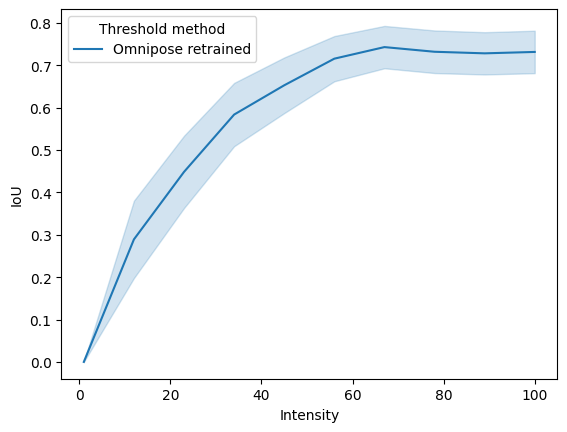

In [32]:
sns.lineplot(x="Intensity", y="IoU", hue="Threshold method", data=all_data_omni_pre, errorbar=("se", 3))

In [ ]:
sns.lineplot(x="Intensity", y="% Error",
             hue="Threshold method",
             data=all_data_omni_pre, errorbar=("se", 3))
#plt.yscale("log")

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(masks[0])

In [ ]:
for name, img in binary_imgs.items():
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.title(name)
    plt.axis("off")
    plt.show()
plt.figure(figsize=(20,20))
plt.imshow(image, cmap="Greys_r")
plt.title("Original")
plt.axis("off")
plt.show()